In [1]:
!git clone https://github.com/atlascu/e_coli-Deep-Learning

Cloning into 'e_coli-Deep-Learning'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 82 (delta 9), reused 77 (delta 6), pack-reused 0
Unpacking objects: 100% (82/82), done.


In [2]:
%cd e_coli-Deep-Learning/src/

/content/e_coli-Deep-Learning/src


In [0]:
import numpy as np
import networkx as nx
import node2vec.src.node2vec as node2vec
from gensim.models import Word2Vec
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn import metrics, model_selection, pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import copy

In [0]:
class Args:
    pass
args = Args()
args.weighted = False
args.input = '../modi_edgelist.csv'
args.output = '../modi_edgelist.emb'
args.directed = False
args.dimensions = 128
args.window_size = 10
args.workers = 8
args.iter = 1
args.p = 1
args.q = 1
args.num_walks = 10
args.walk_length = 80

In [0]:
# get edge list
def get_edge_list_from_nsblR(edge_list_path, majority_applied='super_majority'):
    df = pd.read_csv(edge_list_path)
    df_filtered = df[df[majority_applied] == 1]
    edge_list = df_filtered[['x', 'y']]
    return edge_list

In [0]:
def read_graph(edge_list_path):
    '''
    Reads the input network in networkx.
    '''
    df_edge_list = get_edge_list_from_nsblR(edge_list_path, 'absolute_majority')
    df_train, df_test = train_test_split(df_edge_list, test_size=0.35)

    if args.weighted:
        G_train = nx.from_pandas_edgelist(df_train, source='x', target='y', create_using=nx.Graph())
        G_test = nx.from_pandas_edgelist(df_test, source='x', target='y', create_using=nx.Graph())
    else:
        # train graph
        G_train = nx.from_pandas_edgelist(df_train, source='x', target='y', create_using=nx.Graph())
        for edge in G_train.edges():
            G_train[edge[0]][edge[1]]['weight'] = 1

        # test graph    
        G_test = nx.from_pandas_edgelist(df_test, source='x', target='y', create_using=nx.Graph())
        for edge in G_test.edges():
            G_test[edge[0]][edge[1]]['weight'] = 1

    if not args.directed:
        G_train = G_train.to_undirected()
        G_test = G_test.to_undirected()


    return G_train, G_test

def learn_embeddings(walks):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    walks = [list(map(str, walk)) for walk in walks]
    model = Word2Vec(walks, size=args.dimensions, window=args.window_size, min_count=0, sg=1, workers=args.workers, iter=args.iter)
    model.wv.save_word2vec_format(args.output)
    return model

In [51]:
    df_edge_list = get_edge_list_from_nsblR(args.input, 'absolute_majority')
    df_train, df_test = train_test_split(df_edge_list, test_size=0.35)
    print(df_train.head(5))

          x     y
19608  nupX  yafC
18907  yfcI  purR
10902  yjhU  yidC
566    oxyS  bcsZ
16020  gsiC  yoeB


In [39]:
# Pipeline for representational learning for all nodes in a graph.

nx_G_train, nx_G_test = read_graph(args.input)

# Node embedding for train graph
G_train = node2vec.Graph(nx_G_train, args.directed, args.p, args.q)
G_train.preprocess_transition_probs()
walks = G_train.simulate_walks(args.num_walks, args.walk_length)
model = learn_embeddings(walks)

# Node embedding for test graph
G_test = node2vec.Graph(nx_G_test, args.directed, args.p, args.q)
G_test.preprocess_transition_probs()
walks = G_test.simulate_walks(args.num_walks, args.walk_length)
model = learn_embeddings(walks)

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


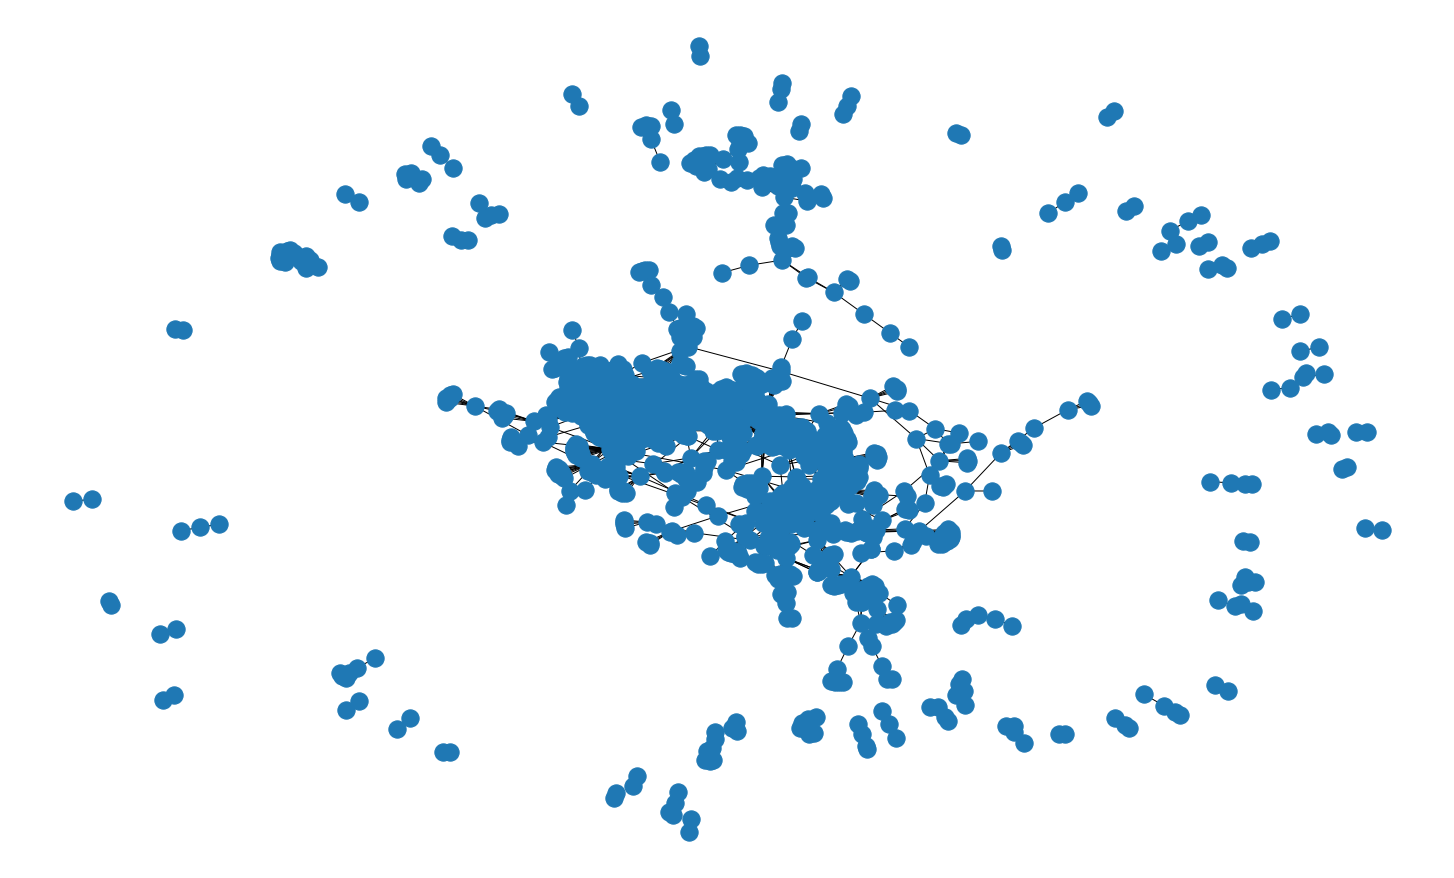

In [40]:
# Plot inferred network
plt.figure(figsize=(20,12))
nx.draw(nx_G_train)

In [0]:
args.prop_pos = 0.5
args.prop_neg = 0.5
args.random_seed = None

In [0]:
def generate_pos_neg_links(graph):
    """
    Select random existing edges in the graph to be postive links,
    and random non-edges to be negative links.
    Modify graph by removing the postive links.
    """
    G = copy.deepcopy(graph)
    rnd = np.random.RandomState(seed=args.random_seed)

    # Select n edges at random (positive samples)
    n_edges = G.number_of_edges()
    n_nodes = G.number_of_nodes()
    npos = int(args.prop_pos * n_edges)
    nneg = int(args.prop_neg * n_edges)

    n_nbs = [len(list(G.neighbors(v))) for v in G.nodes()]
    n_non_edges = n_nodes - 1 - np.array(n_nbs)

    non_edges = [e for e in nx.non_edges(G)]
    print("Finding %d of %d non-edges" % (nneg, len(non_edges)))

    # Select m pairs of non-edges (negative samples)
    rnd_inx = rnd.choice(len(non_edges), nneg, replace=False)
    neg_edge_list = [non_edges[ii] for ii in rnd_inx]

    if len(neg_edge_list) < nneg:
        raise RuntimeWarning(
            "Only %d negative edges found" % (len(neg_edge_list))
        )

    print("Finding %d positive edges of %d total edges" % (npos, n_edges))

    # Find positive edges, and remove them.
    edges = list(G.edges())
    pos_edge_list = []
    n_count = 0
    n_ignored_count = 0
    rnd_inx = rnd.permutation(n_edges)
    for eii in rnd_inx:
        edge = edges[eii]

        # Remove edge from graph
        data = G[edge[0]][edge[1]]
        G.remove_edge(*edge)

        pos_edge_list.append(edge)
        print("Found: %d    " % (n_count + 1), end="\r")
        n_count += 1

        # Exit if we've found npos nodes or we have gone through the whole list
        if n_count >= npos:
            break

    if len(pos_edge_list) < npos:
        raise RuntimeWarning("Only %d positive edges found." % (n_count))

    return pos_edge_list, neg_edge_list

In [43]:
# Collecting positive and negative edge lists for train and test graphs

pos_edge_list_train, neg_edge_list_train = generate_pos_neg_links(nx_G_train)
pos_edge_list_test, neg_edge_list_test = generate_pos_neg_links(nx_G_test)


Finding 905 of 810365 non-edges
Finding 905 positive edges of 1810 total edges
Finding 488 of 404474 non-edges
Finding 488 positive edges of 976 total edges


In [0]:
edge_functions = {
    "hadamard": lambda a, b: a * b,
    "average": lambda a, b: 0.5 * (a + b),
    "l1": lambda a, b: np.abs(a - b),
    "l2": lambda a, b: np.abs(a - b) ** 2,
}

In [0]:
def get_selected_edges(pos_edge_list, neg_edge_list):
    edges = pos_edge_list + neg_edge_list
    labels = np.zeros(len(edges))
    labels[:len(pos_edge_list)] = 1
    return edges, labels

In [0]:
def edges_to_features(edge_list, edge_function, dimensions, model):
    """
    Given a list of edge lists and a list of labels, create
    an edge feature array using binary_edge_function and
    create a label array matching the label in the list to all
    edges in the corresponding edge list
    :param edge_function:
        Function of two arguments taking the node features and returning
        an edge feature of given dimension
    :param dimension:
        Size of returned edge feature vector, if None defaults to
        node feature size.
    :param k:
        Partition number. If None use all positive & negative edges
    :return:
        feature_vec (n, dimensions), label_vec (n)
    """
    n_tot = len(edge_list)
    feature_vec = np.empty((n_tot, dimensions), dtype='f')

    # Iterate over edges
    for ii in range(n_tot):
        v1, v2 = edge_list[ii]

        # Edge-node features
        emb1 = np.asarray(model.wv[str(v1)])
        emb2 = np.asarray(model.wv[str(v2)])

        # Calculate edge feature
        feature_vec[ii] = edge_function(emb1, emb2)

    return feature_vec

In [47]:
cv_aucs = []

# Train and test graphs, with different edges
edges_train, labels_train = get_selected_edges(pos_edge_list_train, neg_edge_list_train)
edges_test, labels_test = get_selected_edges(pos_edge_list_test, neg_edge_list_test)

edge_features_train = edges_to_features(edges_train, edge_functions['hadamard'], args.dimensions, model)
edge_features_test = edges_to_features(edges_test, edge_functions['hadamard'], args.dimensions, model)

# Linear classifier
scaler = StandardScaler()
lin_clf = LogisticRegression(C=1)
clf = pipeline.make_pipeline(scaler, lin_clf)

# Train classifier
clf.fit(edge_features_train, labels_train)

predicts_train = clf.predict(edge_features_train)
auc_train = metrics.roc_auc_score(labels_train, predicts_train)

# Test classifier
predicts_test = clf.predict(edge_features_test)
auc_test = metrics.roc_auc_score(labels_test, predicts_test)

cv_aucs.append(auc_test)

print("AUC train: %.4g AUC test: %.4g"
      % (auc_train, auc_test))

KeyError: ignored